# Предсказание количества золота, извлеченного из золотоносной руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## 1. Подготовка данных

### 1.1. Описание данных

### Технологический процесс

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

### Наименование признаков

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

### 1.2. Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

### 1.3. Чтение файлов и изучение данных

In [2]:
try:
    full = pd.read_csv('gold_industry_full.csv')     
    train = pd.read_csv('gold_industry_train.csv.csv')   
    test = pd.read_csv('gold_industry_test.csv')
except:
    full = pd.read_csv('c:/Users/User/Downloads/gold_industry_full.csv')
    train = pd.read_csv('c:/Users/User/Downloads/gold_industry_train.csv')
    test = pd.read_csv('c:/Users/User/Downloads/gold_industry_test.csv')

In [3]:
datasets = {'Исходные данные': full, 
            'Обучающая выборка': train, 
            'Тестовая выборка': test}

In [4]:
for key, value in datasets.items():
    print(key + ':', value.shape)

Исходные данные: (19439, 87)
Обучающая выборка: (14579, 87)
Тестовая выборка: (4860, 53)


In [5]:
full.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [6]:
full.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


In [7]:
print('Данные доступны за период от', pd.to_datetime(full['date'].min()), 'до', pd.to_datetime(full['date'].max()))

Данные доступны за период от 2016-01-15 00:00:00 до 2018-08-18 10:59:59


### 1.3.1. Расчёт эффективности обогащения

Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака.

Эффективность обогащения рассчитывается по формуле:

$$ Recovery = \frac{C × (F-T)}{F × (C-T)} × 100%$$

где: 

- C — доля золота в концентрате после флотации/очистки
- F — доля золота в сырье/концентрате до флотации/очистки
- T — доля золота в отвальных хвостах после флотации/очистки.

Проверим, правильно ли она расчитана на примере признака *rougher.output.recovery*. 

Выведем на экран все столбцы, названия которых содержит слово *rougher*:

In [8]:
train_temporary = train.copy(deep=True)

In [9]:
[col for col in train_temporary.columns if 'rougher' in col]

['rougher.input.feed_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'rougher.o

Для расчета *Recovery* будем использовать следующие признаки: 

- C — *rougher.output.concentrate_au*
- F — *rougher.input.feed_au*
- T — *rougher.output.tail_au*.

Результат расчета формулы хранится в признаке *rougher.output.recovery*.

In [10]:
C = train_temporary['rougher.output.concentrate_au']
F = train_temporary['rougher.input.feed_au']
T = train_temporary['rougher.output.tail_au']

train_temporary['rougher.output.recovery.checked'] = (C * (F - T)) / (F * (C - T)) * 100
train_temporary['rougher.output.recovery.checked'].head(3)

0    87.107763
1    86.843261
2    86.842308
Name: rougher.output.recovery.checked, dtype: float64

Посчитаем метрику *MAE* между результатом проделанного расчета и значением признака *rougher.output.recovery*. Перед расчетом удалим пропуски из копии датасета *train*. 

In [11]:
train_temporary.dropna(inplace=True)
print('MAE:', 
      mean_absolute_error(train_temporary['rougher.output.recovery'], 
                          train_temporary['rougher.output.recovery.checked']))

MAE: 9.906677443564516e-15


Показатель метрики *MAE* очень низкий, что означает, что эффективность обогащения рассчитана правильно. 

#### 1.3.2. Анализ признаков

Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [12]:
print('К-во признаков, которые недоступны в тестовой выборке:' , len(set(train) - set(test)))
set(train) - set(test)

К-во признаков, которые недоступны в тестовой выборке: 34


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке недоступны признаки из блоков *output* (параметры продукта) и *calculation* (расчётные характеристики). Также в тестовой выборке отсутствуют целевые признаки: 

- *rougher.output.recovery* — эффективность обогащения чернового концентрата

- *final.output.recovery* — эффективность обогащения финального концентрата 

Эти параметры в тестовой выборке недоступны, так как замеряются или рассчитываются значительно позже.


Тип данных отсутствующих признаков: *float64*.

### 1.4. Предобработка данных

Создадим копии датасетов.

In [13]:
full_copy = full.copy(deep=True)
train_copy = train.copy(deep=True)
test_copy = test.copy(deep=True)

datasets_copy = {'Исходные данные': full_copy, 
                 'Обучающая выборка': train_copy, 
                 'Тестовая выборка': test_copy}

In [14]:
for key, value in datasets_copy.items():
    print(key + ':', value.shape)

Исходные данные: (19439, 87)
Обучающая выборка: (14579, 87)
Тестовая выборка: (4860, 53)


Заменим тип данных для признака *date*. 

In [15]:
for key, value in datasets_copy.items():
    value['date'] = pd.to_datetime(value['date'])
    print(value['date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


Обработаем пропуски: 

- добавим в тестовую выборку целевые признаки
- из целевых признаков удалим строки с пропусками 
- для остальных признаков применим метод *ffill* и заполним пропуски с предыдущим значением строки.

In [16]:
test_copy = test_copy.merge(full_copy[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                           how = 'left', on = 'date')
test_copy.shape

(4860, 55)

Заполним пропуски в остальных признаках.

In [17]:
for key, value in datasets_copy.items():
    value.ffill(inplace=True)
    print(value.isnull().values.any())

False
False
False


Из копии обучающей выборки удалим те признаки, которых нету в тестовой. Таким образом в обучающей и в тестовой выборках останутся только те признаки, которые будем использовать при обучении модели (при условии, что эти признаки не коррелируют с целевыми признаками).  

In [18]:
useful_cols = list(test_copy.columns)
train_copy = train_copy[useful_cols]

In [19]:
print('Размер выборки train_copy:', train_copy.shape)
print('Размер выборки test_copy:', test_copy.shape)

Размер выборки train_copy: (14579, 55)
Размер выборки test_copy: (4860, 55)


### Вывод

На этом этапе проекта:

- Загрузили и изучили данные.
- Проверили, что эффективность обогащения рассчитана правильно.
- Проанализировали признаки, недоступные в тестовой выборке.
- Провели предобработку данных:
    - убедились, что в данных отсутствуют дубликаты
    - обработали пропуски
    - заменили тип данных для признака *date*
    - подготовили обучающую и тестовую выборки для дальнейшей работы: оставили в обоих выборках одинаковое к-во признаков.  


## 2. Анализ данных

### 2.1. Анализ концентрации металлов на различных этапах очистки

Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Из копии датасета с исходными данными отберем признаки, которые характеризуют концентрацию металлов (Au, Ag, Pb) на различных этапах очистки. 

In [20]:
elements = {'золото': 'au', 'серебро': 'ag', 'свинец': 'pb'}
elements

{'золото': 'au', 'серебро': 'ag', 'свинец': 'pb'}

Функция для визуализации концентрации металлов (Au, Ag, Pb) на различных этапах очистки. 

In [21]:
def concentrate_viz(e):
           
    cols = ['rougher.input.feed_'+e, 'rougher.output.concentrate_'+e, 
            'primary_cleaner.output.concentrate_'+e, 'final.output.concentrate_'+e]
    
    concentrate = full_copy[cols]    
    
    sns.displot(full_copy[cols], 
            legend=True, 
            kde=True, 
            height=7.7, 
            aspect=1.5)
    
    plt.title('Концентрация металла ' + str(e).title() + ' на различных этапах очистки', fontsize=16)
    plt.xlabel("Этап", fontsize=14)
    plt.ylabel("Концентрация", fontsize=14)
    
    
    plt.figure(figsize=(12.8,8))
    plt.title('Концентрация металла ' + str(e).title() + ' на различных этапах очистки', fontsize=16)
    plt.xticks(rotation=0)
    plt.xlabel("Этап", fontsize=14)
    plt.ylabel("Концентрация", fontsize=14)
    sns.boxplot(data=full_copy[cols])

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


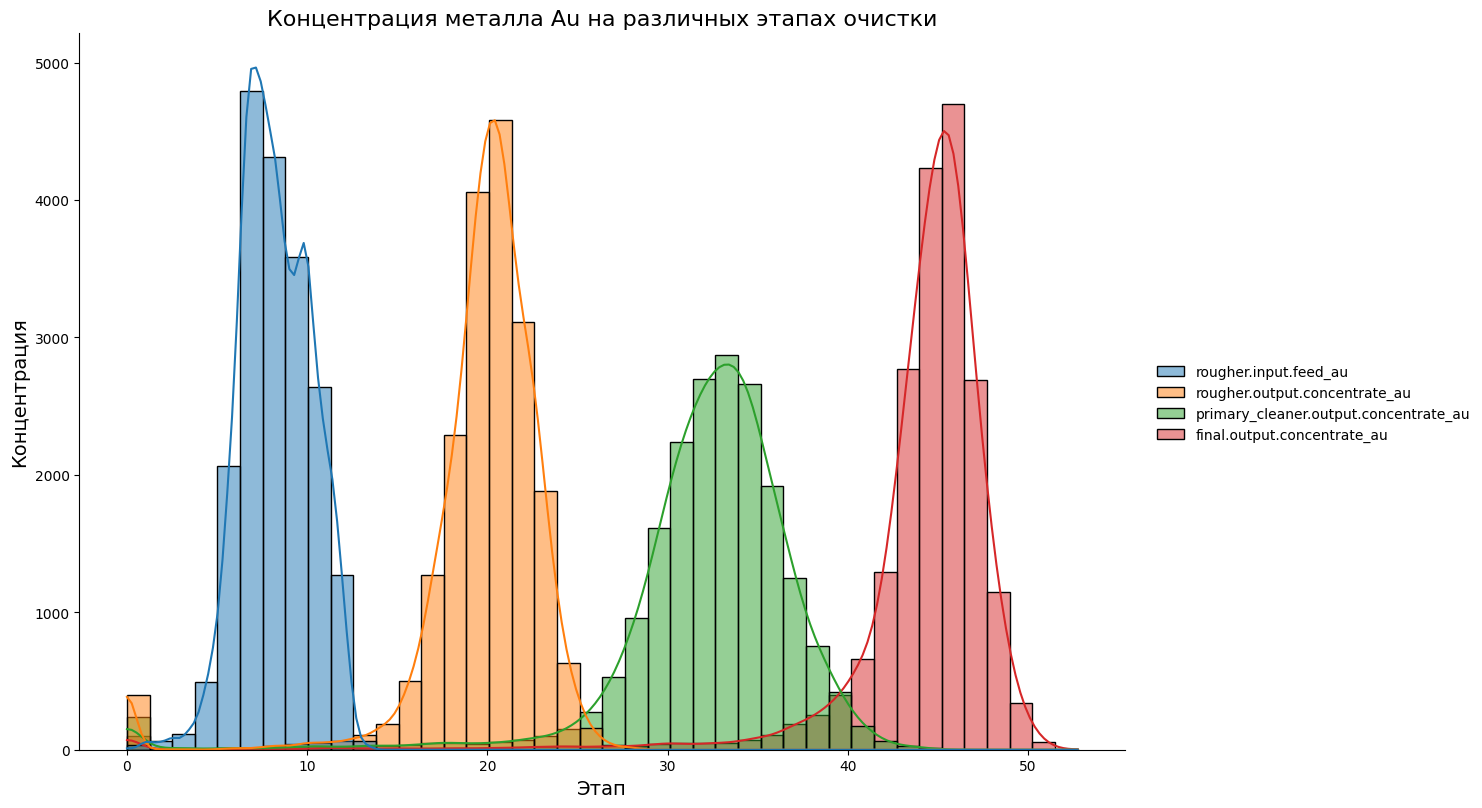

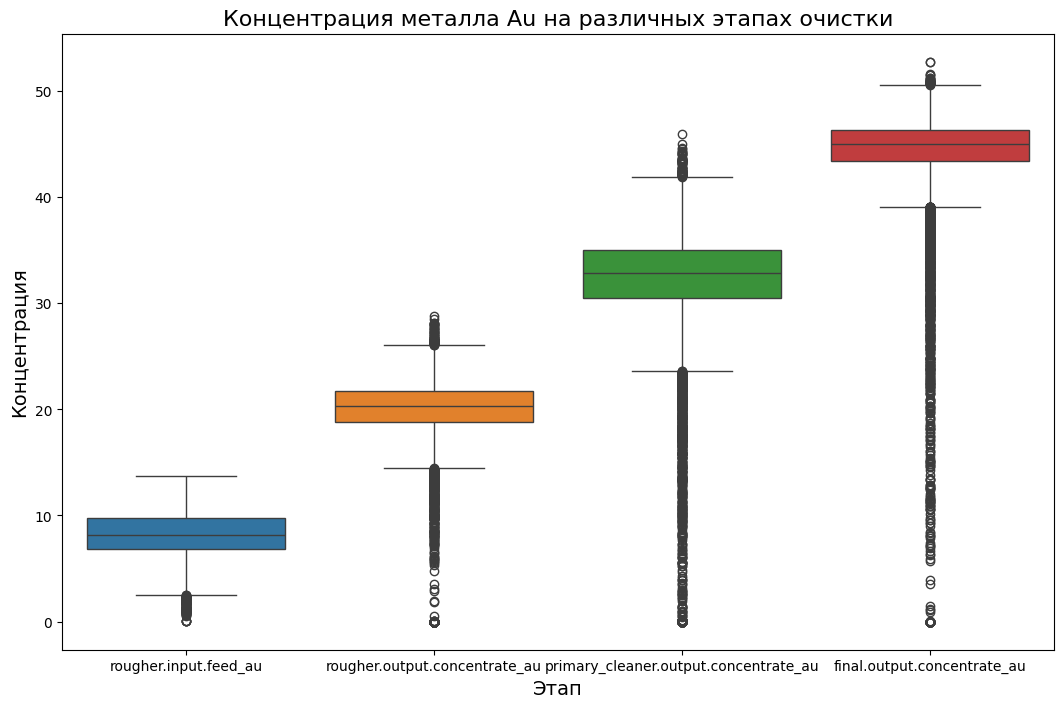

In [22]:
concentrate_viz(elements['золото'])

Видим, что концентрация золота с каждым этапом очистки увеличивается. Наименьшая концентрация золота на этапе *rougher.input.feed_au* (сырье), а самый высокий на финальном этапе *final.output.concentrate_au*, т.е., после того, как концентрат прошел все стадии очистки. Это вполне логично и соответствует технологическому процессу очистки золотоносной руды.

Стоит отметить, что по длинным хвостам графиков мы можем сделать вывод о том, что в данных присутствуют выбросы (на всех этапах очистки).

Посмотрим на концентрацию серебра. 

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


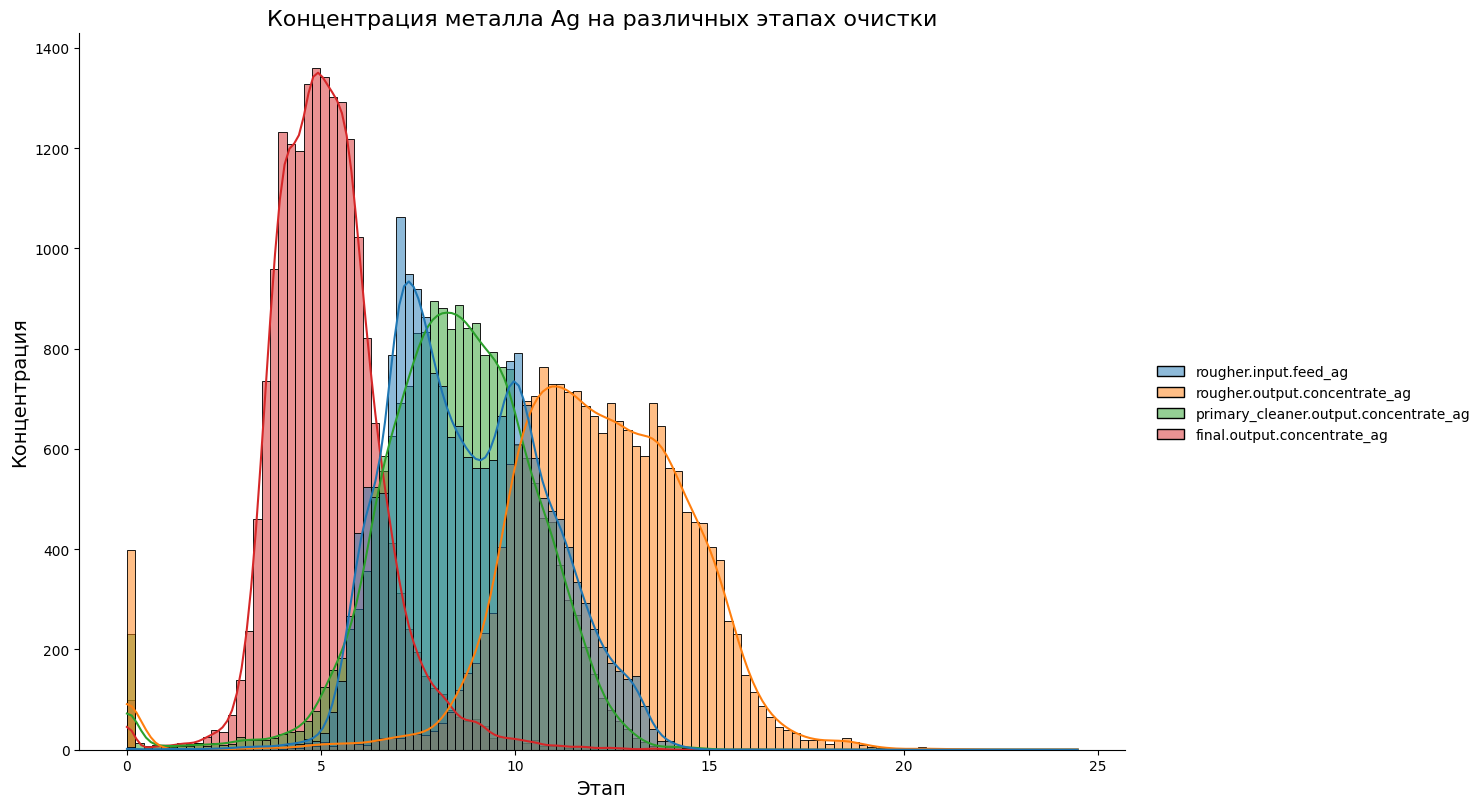

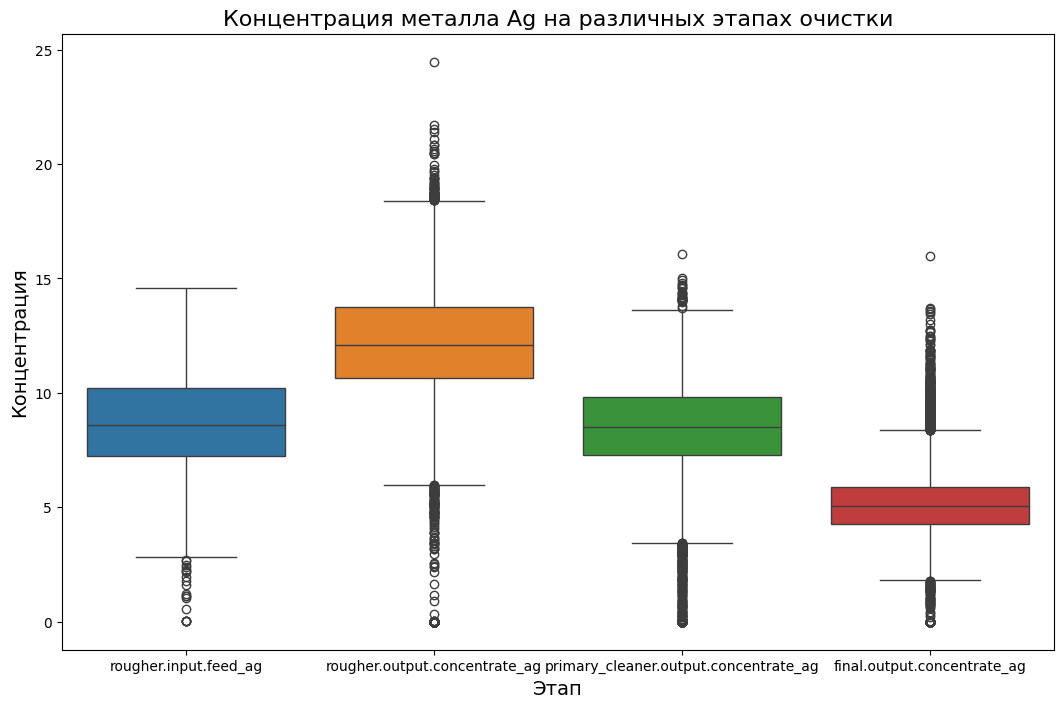

In [23]:
concentrate_viz(elements['серебро'])

В отличии от золота, концентрация серебра с каждым этапом очистки уменьшается, а на финальном этапе показатель концентрации серебра даже ниже, чем на первом этапе очистки. Максимальную концентрацию серебра мы видим после второго этапа очистки. В данных присутствуют выбросы.

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


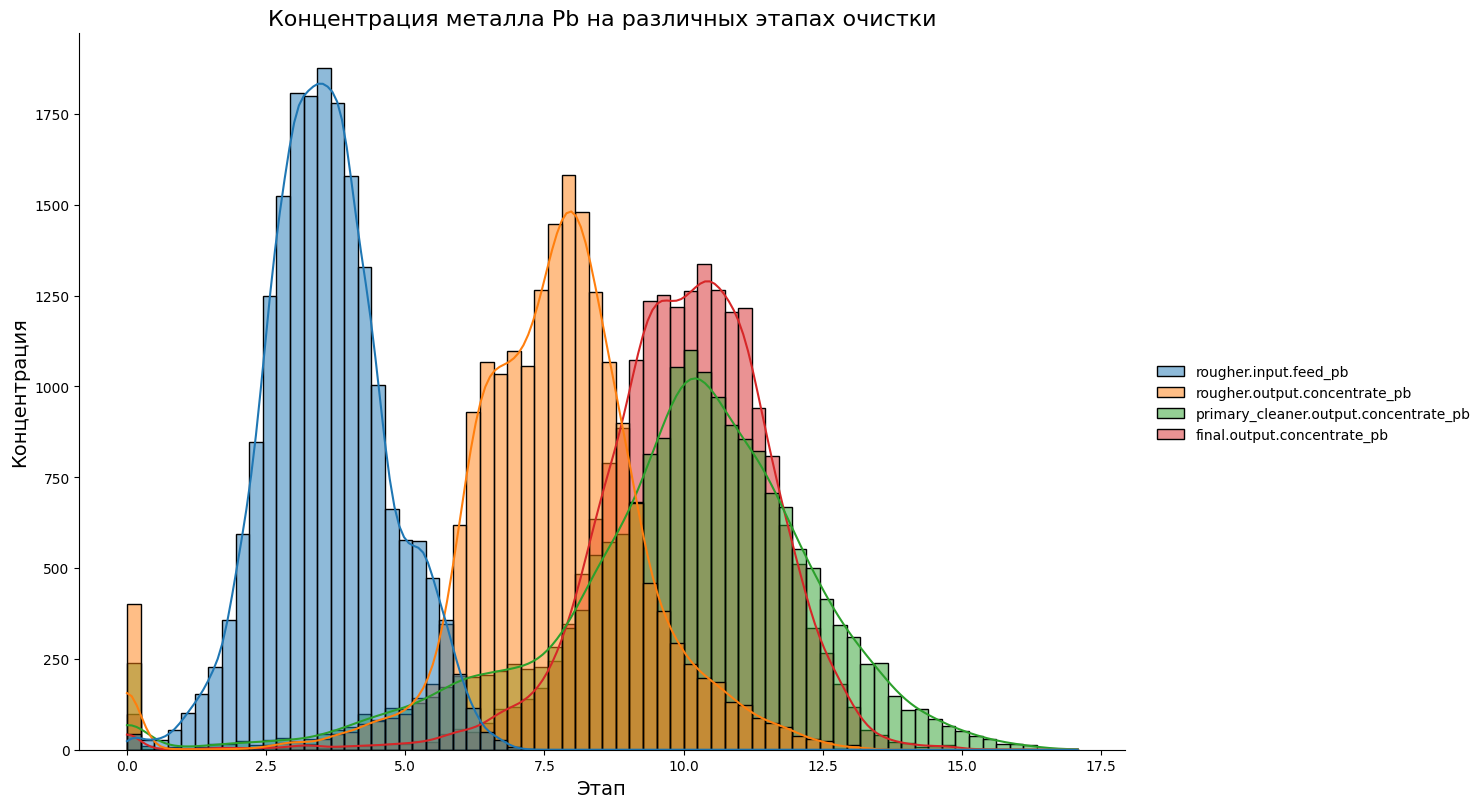

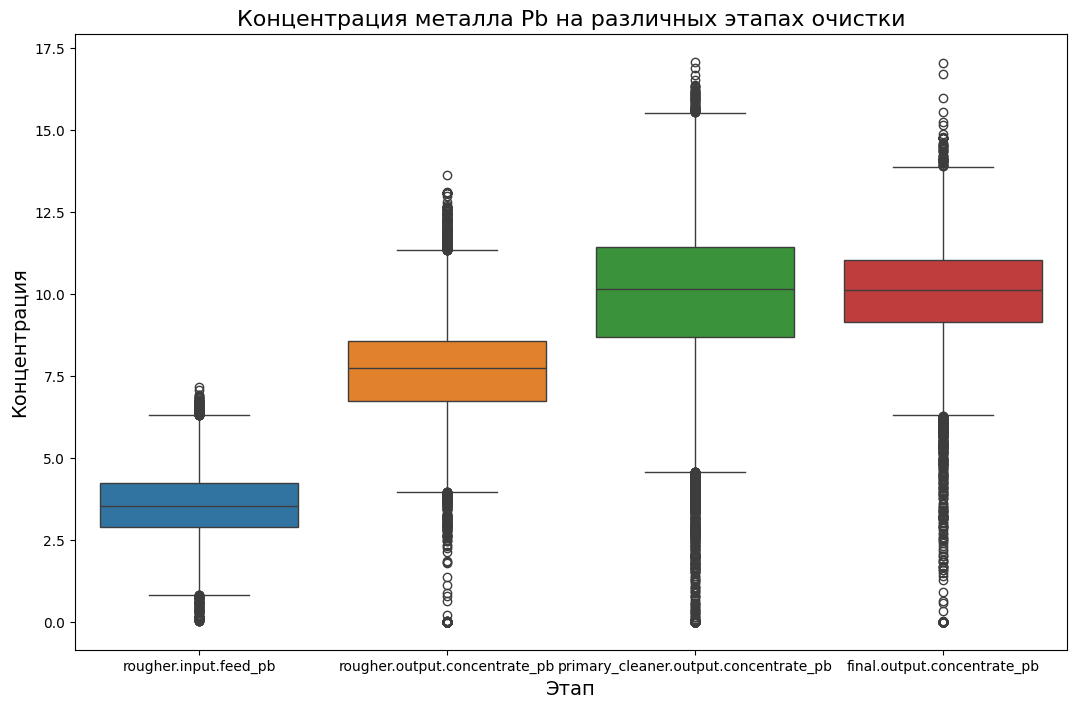

In [24]:
concentrate_viz(elements['свинец'])

Из графиков выше видим, что концентрация свинца постепенно растет на первых 3-х этапах очистки. Меньше всего свинца в начале процесса, т.е., тогда, когда он входит в состав смеси золотосодержащей руды. Интересно, что на последних 2-х этапах показатель медианы почти совпадает, но при этом на финальной стадии уменьшается разброс значений. 

Так же видим, что в данных на всех стадиях очистки присутствуют выбросы. Их стоит удалить, чтобы они негативно не повлияли на работу будущей модели. 

А еще, что для некоторых объектов суммарное концентрация всех металлов на этапах *черновой концентрат*, *концентрат после очистки* и *финальный концентрат* составляет 0. Такие объекты удалим, так как они не несут никакого смысла и могут негативно повлиять на работу модели. 

Проверим, сколько объектов, где суммарная концентрация металлом равна 0 и сколько таких, где меньше 1. 

In [25]:
first = 'rougher.input.feed_'
second = 'rougher.output.concentrate_'
third = 'primary_cleaner.output.concentrate_'
fourth = 'final.output.concentrate_'

full_copy['сырье'] = full_copy[[first+'au', first+'ag', first+'pb']].sum(axis=1)
full_copy['черновой концентрат'] = full_copy[[second+'au', second+'ag', second+'pb']].sum(axis=1)
full_copy['концентрат после очистки'] = full_copy[[third+'au', third+'ag', third+'pb']].sum(axis=1)
full_copy['финальный концентрат'] = full_copy[[fourth+'au', fourth+'ag', fourth+'pb']].sum(axis=1)

In [26]:
cols_all = ['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']

for col in cols_all:
    print(col, 'zeros:', len(full_copy[full_copy[col] == 0]))
    print(col, 'under 1:', len(full_copy[full_copy[col] < 1]))
    print('\n')

сырье zeros: 0
сырье under 1: 5


черновой концентрат zeros: 394
черновой концентрат under 1: 399


концентрат после очистки zeros: 108
концентрат после очистки under 1: 229


финальный концентрат zeros: 98
финальный концентрат under 1: 99




Обновим копию исходных данных и оставим там только те объекты, где суммарная концентрация металлом не меньше 1. 

In [27]:
full_clean = full_copy[
    (full_copy['сырье'] >  1) & 
    (full_copy['черновой концентрат'] > 1) & 
    (full_copy['концентрат после очистки'] > 1) & 
    (full_copy['финальный концентрат'] > 1)
]

full_clean.shape

(18721, 91)

Проверка результата. 

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(9.155077160493848, 0.5, 'Концентрация')

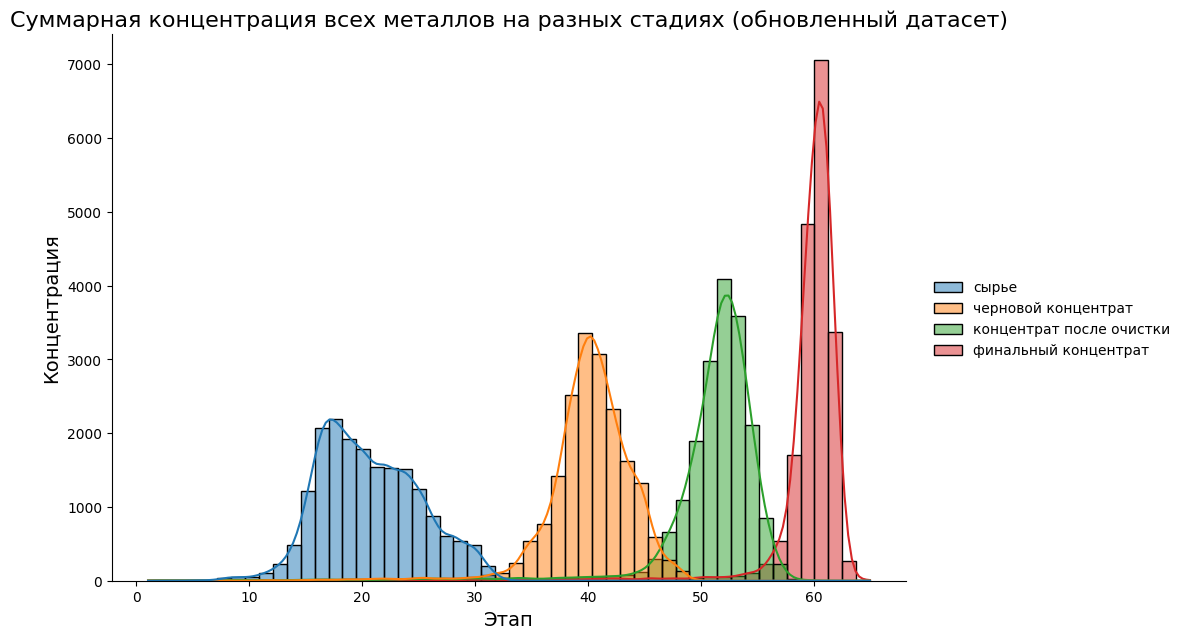

In [28]:
sns.displot(full_clean[['сырье', 'черновой концентрат', 
                       'концентрат после очистки', 'финальный концентрат']], 
            legend=True, 
            kde=True, 
            height=6, 
            aspect=1.5)
plt.title('Суммарная концентрация всех металлов на разных стадиях (обновленный датасет)', fontsize=16)
plt.xlabel("Этап", fontsize=14)
plt.ylabel("Концентрация", fontsize=14)

In [29]:
full_clean[['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']].describe()

,сырье,черновой концентрат,концентрат после очистки,финальный концентрат
count,18721.000000,18721.000000,18721.000000,18721.000000
mean,20.649641,40.212048,50.963042,59.537313
std,4.432921,3.823193,5.210567,4.263810
min,2.560855,1.137053,1.037408,1.685441
25%,17.238008,38.537325,50.124496,59.307366
50%,20.136186,40.381394,51.917202,60.303141
75%,23.787611,42.411418,53.362292,61.086650
max,33.498784,55.568687,60.106566,64.968881


Видим, что сейчас на всех стадиях минимальный показатель суммарной концентрации всех металлов выше 1, аномалий больше не наблюдается. Видим, что такой подход позволил уменьшить разброс данных, о чем свидетельствует сравнительно низкие показатели стандартного отклонения *(std)*. 

Удалим из обучающего и тестового датасета те объекты, которые мы только что удалили из датасета *full_clear*.

Объекты, которые необходимо удалить, можно отобрать по признаку *date*.

In [30]:
train_clean = train_copy[train_copy['date'].isin(full_clean['date'])]
test_clean = test_copy[test_copy['date'].isin(full_clean['date'])]

train_clean.dropna(inplace=True) 
test_clean.dropna(inplace=True)  
print('Обучающая выборка', train_clean.shape)
print('Тестовая выборка', test_clean.shape)

Обучающая выборка (13883, 55)
Тестовая выборка (4518, 55)


C:\Users\User\AppData\Local\Temp\ipykernel_11744\1453348745.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean.dropna(inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_11744\1453348745.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean.dropna(inplace=True)


### 2.2. Анализ размера гранул на обучающей и тестовой выборках

Сравните распределения размеров гранул исходного сырья на обучающей и тестовой выборках.

Чтобы сравнить распределения размеров гранул сырья на обучающей и тестовой выборках:
- методом *describe()* посмотрим на статистические данные признаков *primary_cleaner.input.feed_size* и *rougher.input.feed_size* на обучающей и тестовой выборках
- построим график распределение размеров гранул сырья на обучающей и тестовой выборках.

In [31]:
rougher_input_feed_size = pd.concat([train_clean['rougher.input.feed_size'], 
                                     test_clean['rougher.input.feed_size']], axis=1) 
rougher_input_feed_size.columns = ['train', 'test']
rougher_input_feed_size.describe()

,train,test
count,13883.000000,4518.000000
mean,59.099870,58.709161
std,23.123463,19.173195
min,0.049194,0.046369
25%,47.315053,47.584338
50%,54.483541,55.139446
75%,64.310460,65.644579
max,484.967466,363.989699


Text(0, 0.5, 'Плотность')

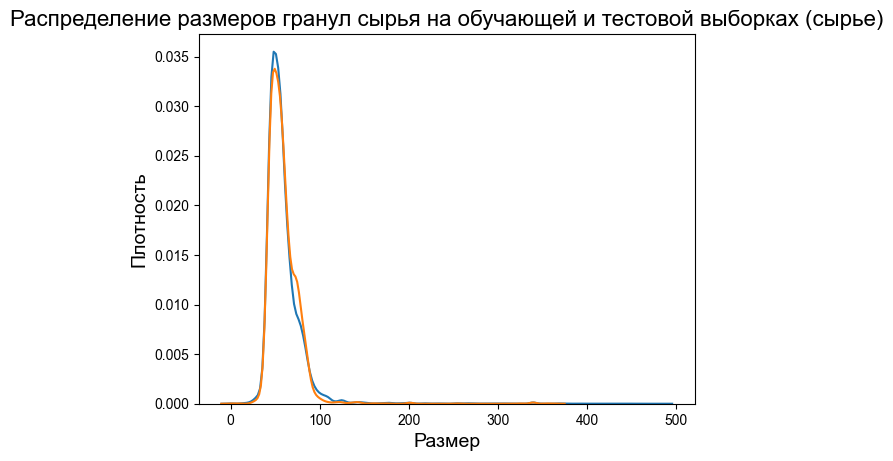

In [32]:
sns.kdeplot(data=train_clean['rougher.input.feed_size'].dropna(), label='data_train')
sns.kdeplot(data=test_clean['rougher.input.feed_size'].dropna(), label='data_test')

sns.set(rc={'figure.figsize':(12, 8)})
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках (сырье)', fontsize=16)
plt.xlabel("Размер", fontsize=14)
plt.ylabel("Плотность", fontsize=14)

Размеры гранул примерно одинаково распределены на обучающей и тестовой выборках. Можем предположит, что те незначительные различия, которые все-таки имеются, не будет негативно влиять на работу модели.

### 2.3. Анализ суммарной концентрации всех металлов на разных стадиях

Исследуйте суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Axes: title={'center': 'Суммарная концентрация всех металлов на разных стадиях'}, xlabel='Этап', ylabel='Концентрация'>

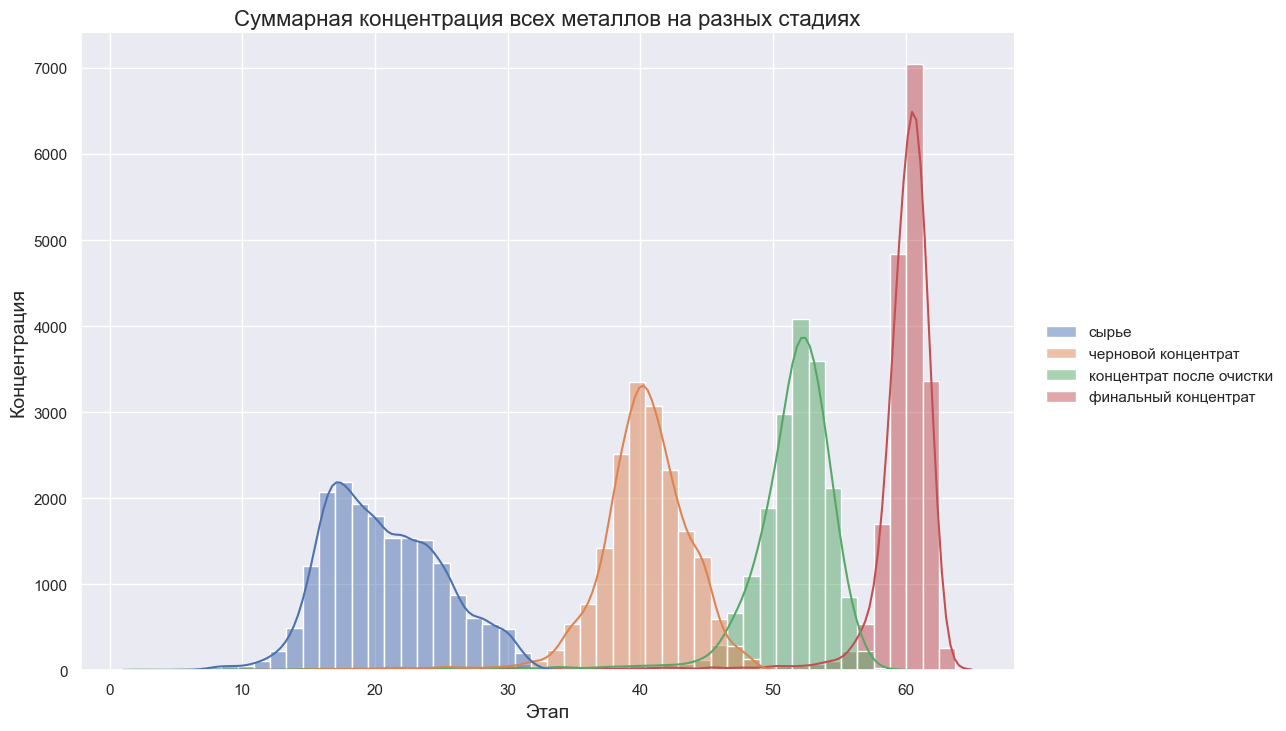

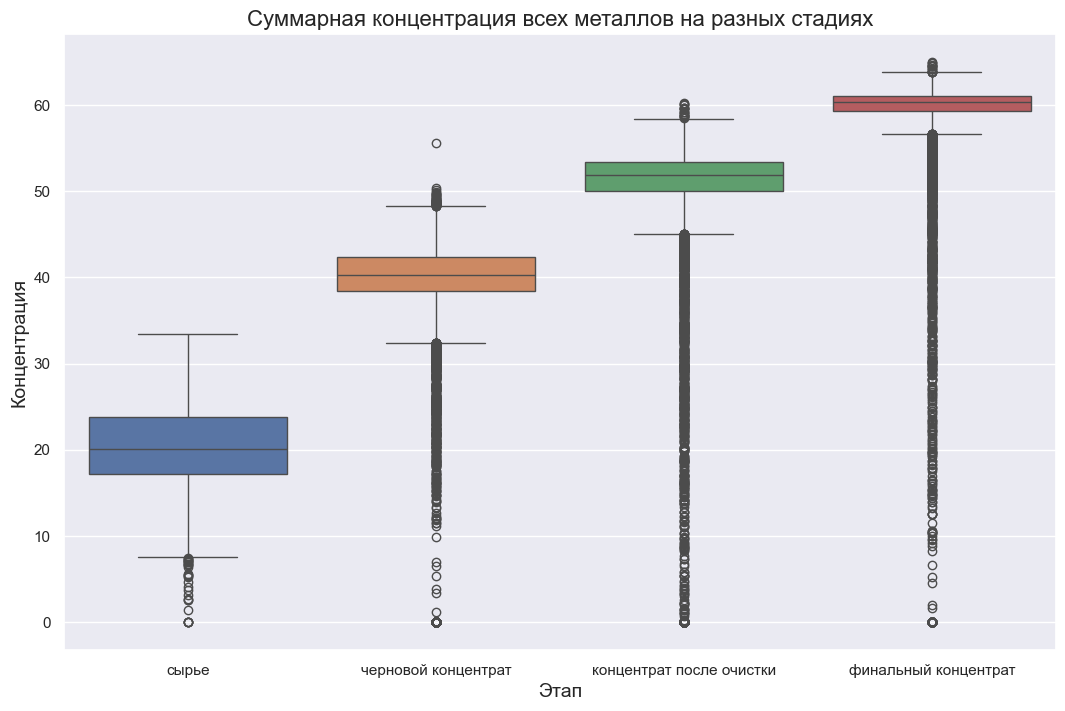

In [33]:
concentrate = full_clean[cols_all]    
    
sns.displot(full_clean[cols_all], 
            legend=True, 
            kde=True, 
            height=7, 
            aspect=1.5)
    
plt.title('Суммарная концентрация всех металлов на разных стадиях', fontsize=16)
plt.xlabel("Этап", fontsize=14)
plt.ylabel("Концентрация", fontsize=14)

    
plt.figure(figsize=(12.8,8))
plt.title('Суммарная концентрация всех металлов на разных стадиях', fontsize=16)
plt.xlabel("Этап", fontsize=14)
plt.ylabel("Концентрация", fontsize=14)
plt.xticks(rotation=0)
sns.boxplot(data=full_copy[cols_all])

Видим, что суммарная концентрация металлов при очистке растёт, значит тех процесс работает правильно.

### Вывод

На этом этапе проекта:

1) Проверили, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

- Можно сделать вывод, что концентрация каждого из металлов меняется в зависимости от этапа очистки. Так, например,  концентрация золота постепенно увеличивается с каждым  этапом, а серебра — падает. 

- Концентрация свинца растёт на первых 3-х этапах. В финальном концентрате медианный показатель концентрации свинца почти такой же, как на предыдущем шаге, но при этом на финальной стадии гораздо ниже показатель разброса значений. 

- Отметили, что на всех этапах очистки в данных присутствуют выбросы.  


2) Провели анализ размера гранул на обучающей и тестовой выборках и убедились, что размеры гранул примерно одинаково распределены в обоих выборках.

3) Провели анализ суммарной концентрации всех металлов на разных стадиях, обнаружили и удалили аномалии (большое к-во 0) из всех датасетов. 
    

## 3. Модель

Напишите функцию для вычисления итоговой sMAPE.

Метрика *sMAPE* вычисляется по следующей формуле: 

$$ sMAPE = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} × 100% $$


где: 

- $y_i$ — значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
- $\hat{y_i}$ — значение предсказания для объекта с порядковым номером i, например, в тестовой выборке
- N — количество объектов в выборке
- $\sum_{i=1}^{N}$ — суммирование по всем объектам выборки (i меняется от 1 до N).

In [34]:
def smape(target, predictions):
    numerator = abs(predictions - target)
    denominator = (abs(target) + abs(predictions)) / 2
    summa = (numerator / denominator).sum()

    smape = 1 / len(target) * summa * 100
    return smape

Итоговая метрика качества *sMAPE final* складывается из двух величин: 

$$ sMAPE final = 0.25 × sMAPE(rougher) + 0.75 × sMAPE(final)$$

Напишем функцию для расчета *sMAPE final*.

In [35]:
def smape_final(smape_rougher, smape_final):
    smape_final = 0.25 * smape_rougher + 0.75 * smape_final
    return smape_final

### 3.2. Обучение и сравнение моделей

Обучите разные модели и оцените их качество кросс-валидацией.

Сохраним признаки и целевые признаки в отдельные переменные.  

In [36]:
target_rougher_train = train_clean['rougher.output.recovery']
target_final_train = train_clean['final.output.recovery']
features_train = train_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

target_rougher_test = test_clean['rougher.output.recovery']
target_final_test = test_clean['final.output.recovery']
features_test = test_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

print('features_train', features_train.shape)
print('features_test', features_test.shape)

features_train (13883, 52)
features_test (4518, 52)


Приведем признаки к одному масштабу. Для этого будем использовать структуру для стандартизации данных из библиотеки *sklearn* — *StandardScaler*.

In [37]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [38]:
features_train.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.990177,-1.455118,-1.230769,0.045717,0.448784,-0.156266,-0.122481,-0.012804,-0.637496,-0.243992,...,-0.904312,-0.366242,-0.565452,-0.670617,-1.023513,-0.307440,-0.746159,-0.380134,-0.886385,-2.720394
1,-0.994165,-1.423311,-1.248568,-0.157988,0.465120,-0.078763,-0.127060,-0.014768,-0.633898,-0.201884,...,-0.909065,-0.427984,-0.596293,-0.619819,-1.002350,-0.360311,-0.764383,-0.383045,-0.914203,-2.556352
2,-1.055483,-1.446699,-1.348886,-0.115857,0.509474,-0.068730,-0.142081,0.154444,-0.637417,-0.201977,...,-0.904665,-0.366916,-0.604085,-0.616845,-0.996451,-0.359150,-0.758792,-0.381354,-0.908692,-2.600789
3,-1.184079,-1.485005,-1.463725,0.056074,0.627139,-0.056531,-0.228337,0.159567,-0.636826,-0.203304,...,-0.900504,-0.332851,-0.586173,-0.617750,-1.015180,-0.332782,-0.765810,-0.374505,-0.912894,-2.562013
4,-1.423576,-1.475785,-1.700289,-0.429359,0.607860,-0.132021,-0.427962,0.155724,-0.637671,-0.198596,...,-0.902287,-0.311993,-0.595768,-0.615652,-1.023499,-0.403430,-0.781763,-0.377126,-0.914513,-2.602668


Оценим качество разных моделей при помощи кросс-валидации. 

In [39]:
random_state = 12345
cv = 5

In [40]:
models = [DecisionTreeRegressor(random_state = random_state), 
          RandomForestRegressor(random_state=random_state), 
          LinearRegression()]

In [41]:
%%time
results_cross_val = []

for model in models: 
    
    scorer = make_scorer(smape, greater_is_better=False) 
    
    cross_val_score_rougher = cross_val_score(model, 
                                              features_train, 
                                              target_rougher_train, 
                                              cv=cv, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model, 
                                            features_train, 
                                            target_final_train, 
                                            cv=cv, scoring=scorer).mean()

    results_cross_val.append({'model name': model.__class__.__name__, 
                              'cross_val_score_rougher': -cross_val_score_rougher, 
                              'cross_val_score_final': -cross_val_score_final}) 
              
pd.DataFrame(results_cross_val)

CPU times: total: 36min 28s
Wall time: 36min 30s


,model name,cross_val_score_rougher,cross_val_score_final
0,DecisionTreeRegressor,9.275461,15.636537
1,RandomForestRegressor,6.888177,9.574435
2,LinearRegression,7.151617,9.444373


Наилучший результат показывает модель случайного леса. Подберем гиперпараметры и попробуем улучшить работу модели.

In [47]:
%%time 
results = []

for depth in range(1,5):
    
    for estimator in range(10, 21, 5):
        
        model = RandomForestRegressor(random_state=random_state, 
                                       n_estimators=estimator, 
                                       max_depth=depth)
        
        scorer = make_scorer(smape, greater_is_better=False) 
    
        cross_val_score_rougher = cross_val_score(model, features_train, target_rougher_train, cv=cv, scoring=scorer).mean()
        cross_val_score_final = cross_val_score(model, features_train, target_final_train, cv=cv, scoring=scorer).mean()

        smape_final_result = smape_final(cross_val_score_rougher, cross_val_score_final)

        results.append({'model name': model.__class__.__name__, 
                        'Hyperparameters': {'random_state': random_state, 
                                            'n_estimators': estimator, 
                                            'max_depth':depth}, 
                        'smape_final_result': -smape_final_result})

pd.DataFrame(results)

CPU times: total: 9min 7s
Wall time: 9min 10s


,model name,Hyperparameters,smape_final_result
0,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 10, 'm...",8.589984
1,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 15, 'm...",8.597519
2,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 20, 'm...",8.570217
3,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 10, 'm...",8.340741
4,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 15, 'm...",8.335914
5,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 20, 'm...",8.304189
6,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 10, 'm...",8.620746
7,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 15, 'm...",8.552993
8,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 20, 'm...",8.487102
9,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 10, 'm...",8.609073


Видим, что подбор гиперпараметров значительно улучшил работу модели. Протестируем работу модели случайного леса с гиперпараметрами *n_estimators* = 20 и *max_depth* = 2 на тестовой выборке. 

### 3.3. Проверка модели на тестовой выборке

Обучим модель случайного леса с гиперпараметрами *n_estimators* = 20 и *max_depth* = 2 на тестовой выборке. 

In [48]:
model_final = RandomForestRegressor(random_state=random_state, 
                                       n_estimators=20, 
                                       max_depth=2)

model_final.fit(features_train, target_rougher_train)
predictions_r = model_final.predict(features_test)

model_final.fit(features_train, target_final_train)
predictions_f = model_final.predict(features_test)

In [49]:
smape_r = smape(target_rougher_test, predictions_r)
smape_f = smape(target_final_test, predictions_f)

print('Итоговое sMAPE:', smape_final(smape_r, smape_f))

Итоговое sMAPE: 7.409179824834169


### 3.4. Проверка модели на адекватность

Для проверки модели на адекватность можно использовать регрессор *DummyRegressor* из библиотеки *Skelarn*.

In [50]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train, target_rougher_train)
predictions_r_dummy = dummy_regr.predict(features_test)

dummy_regr.fit(features_train, target_final_train)
predictions_f_dummy = dummy_regr.predict(features_test)

In [51]:
smape_r_dummy = smape(target_rougher_test, predictions_r_dummy)
smape_f_dummy = smape(target_final_test, predictions_f_dummy)

print('Итоговое sMAPE', smape_final(smape_r_dummy, smape_f_dummy))

Итоговое sMAPE 8.349982856529003


Обученная модель работает чуть лучше чем константная модель: ошибка обученной модели составляет 7.4%, константной - 8.35%.

### Вывод

- Написали функции для расчёта sMAPE и итоговой sMAPE
- Сравнили работу разных моделей (DecisionTreeRegressor, RandomForestRegressor, LinearRegression).
- протестили модель случайного леса с гиперпараметрами n_estimators = 20 и max_depth = 2 на тестовой выборке и проверили модель на адекватность. Можем сделать вывод, что обученная модель работает лучше чем константная модель: ошибка обученной модели составляет 7.4%, константной - 8.35%.

# 4. Общий вывод

Цель проекта - подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды - достигнута. 

Во время проекта обработали и проанализировали данные, на основе которых построили и обучили модель случайного леса. Финальная модель работает лучше чем константная модель: ошибка обученной модели составляет 7.4%, константной - 8.35%.